In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from data_loader import get_merged_scores_df
from plots_helper import *

In [2]:
df = get_merged_scores_df("popu_freq", home_dir)
df = df[~pd.isna(df["phastCons17way_primate"]) & (df["class"]!="Singleton")]  # taking df for only non-NAN values
df["class"].value_counts()

Index(['snp_id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'wt_population',
       'mut_poulation', 'wt_freq', 'mt_freq', 'class', 'chrom', 'sift',
       'polyphen2_HVAR', 'metarnn', 'revel', 'mvp', 'cadd_raw',
       'integrated_fitCons', 'phyloP17way_primate', 'phastCons17way_primate',
       'bStatistic', 'n_methods_having_preds', 'esm1b_t33_650M_UR50S',
       'esm1v_t33_650M_UR90S', 'esm2_t33_650M_UR50D', 'prottrans_bert_bfd',
       'prottrans_t5_xl_u50', 'vespa', 'proteinbert', 'sequnet', 'protbert',
       'unirep', 'conservation'],
      dtype='object')
(26409, 37)
Common        6976
Ultra-rare    6957
Singleton     6955
Rare          5521
Name: class, dtype: int64


Common        6975
Ultra-rare    6957
Rare          5521
Name: class, dtype: int64

In [10]:
model_pred_col = "phastCons17way_primate"
df[model_pred_col]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]

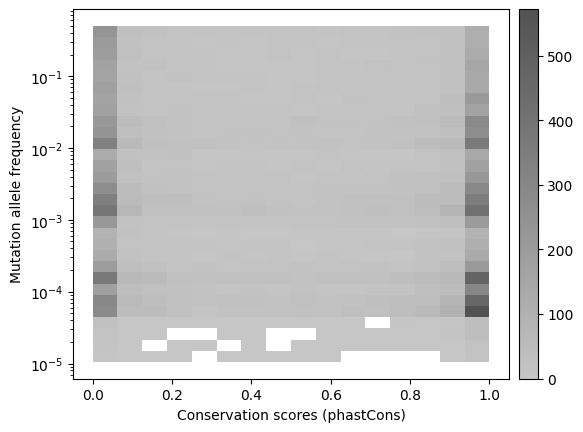

In [15]:
# Conservation vs. mutation allele frequency
plt.clf()
ax = sns.histplot(data=df, x="phastCons17way_primate", y="mt_freq", log_scale=(False, True), color="gray", cbar=True, cbar_kws=dict(fraction=.1, pad=.02))#, hue="class", palette=popu_freq_colors_dict, hue_order=popu_freq_class_order_wo_singleton)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Conservation scores (phastCons)")
plt.ylabel("Mutation allele frequency")
# plt.show()
plt.savefig(home_dir+f"models/aa_common/plots_conservation_vs_scores_histogram/conservation_vs_mt_allele_freq.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)

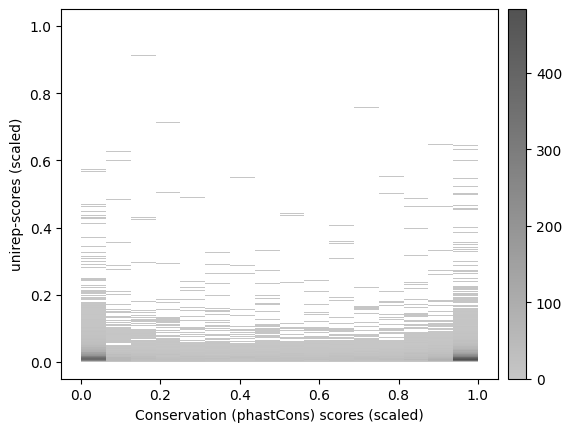

In [16]:
# Conservation vs. models predictions
def do_hist_plot(df, method_name):
    ax = sns.histplot(data=df, x="phastCons17way_primate", y="pred", color="gray", cbar=True, cbar_kws=dict(fraction=.1, pad=.02)) # hue="class" , palette=popu_freq_colors_dict, hue_order=popu_freq_class_order_wo_singleton)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xlabel("Conservation (phastCons) scores (scaled)")
    plt.ylabel(f"{method_name}-scores (scaled)")


def find_and_plot_th(df, method_name): # finding a th such that >99% of the common variants are correctly classified
    df.loc[df["class"]=="Common", "class_numeric"] = 1
    df.loc[df["class"]!="Common", "class_numeric"] = 0

    best_th = 0.0
    if method_name in all_methods_smaller_means_damaging: 
        ths = np.arange(1.1, 0, -.01)
        pos_class_numeric_assigned, neg_class_numeric_assigned = 1, 0
        direction = r'$\uparrow$'
    else: 
        ths = np.arange(0, 1.1, .01)
        pos_class_numeric_assigned, neg_class_numeric_assigned = 0, 1
        direction = r'$\downarrow$'


    for th in ths:
        df.loc[df["pred"]<=th, "class_numeric_assigned"] = neg_class_numeric_assigned
        df.loc[df["pred"]>th, "class_numeric_assigned"] = pos_class_numeric_assigned

        temp_df = df[df["class"]=="Common"]
        n_rows_annotated_as_common = temp_df[temp_df["class_numeric"]==temp_df["class_numeric_assigned"]]
        percentage = n_rows_annotated_as_common.shape[0]/temp_df.shape[0]
        if percentage >= .99:
            print("\t", th, percentage)
            best_th = th
            break
    
    if method_name in all_methods_smaller_means_damaging: best_th_yaxis_pos = best_th+.02
    else: best_th_yaxis_pos = best_th-.05
    
    plt.axhline(y=best_th, color='r', linestyle='dashed')
    plt.text(0.7, best_th_yaxis_pos, f"{direction}th={best_th:.2f}", c="r")


for i, method_name in enumerate(method_names):
    plt.clf()
    # method_name = "esm1b_t33_650M_UR50S"
    if method_name=="phastCons17way_primate": continue
    if method_name=="random_classifier": df[method_name] = [random.uniform(0, 1) for i in range(df.shape[0])]

    non_nan_df = df[~pd.isna(df[method_name])].copy()  # taking df for only non-NAN values
    non_nan_df["pred"]=(non_nan_df[method_name]-non_nan_df[method_name].min())/(non_nan_df[method_name].max()-non_nan_df[method_name].min()) # scaling prediction scores between [0, 1]

    # find_and_plot_th(non_nan_df, method_name)
    do_hist_plot(non_nan_df, method_name)

    # plt.show()
    plt.savefig(home_dir+f"models/aa_common/plots_conservation_vs_scores_histogram/{method_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)
    # if i==1: break